In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-09-24 12:11:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.01s   

2021-09-24 12:11:31 (4.75 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



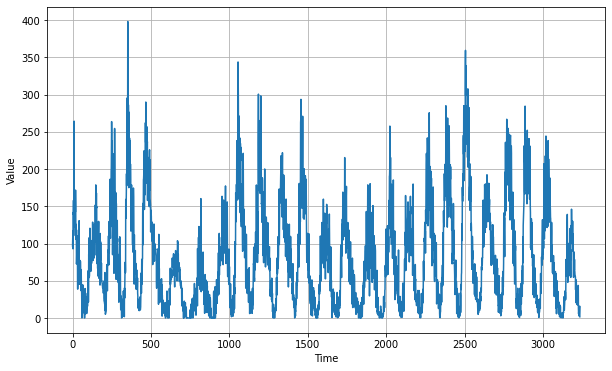

In [4]:
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as file:
  reader = csv.reader(file, delimiter = ',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
    
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size,
                             shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 100,
                    callbacks = [lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
12/12 [==============================] - 7s 298ms/step - loss: 81.4328 - mae: 81.9305
Epoch 2/100
12/12 [==============================] - 4s 300ms/step - loss: 80.2590 - mae: 80.7567
Epoch 3/100
12/12 [==============================] - 4s 296ms/step - loss: 78.5311 - mae: 79.0287
Epoch 4/100
12/12 [==============================] - 4s 295ms/step - loss: 76.5364 - mae: 77.0339
Epoch 5/100
12/12 [==============================] - 4s 298ms/step - loss: 74.4509 - mae: 74.9484
Epoch 6/100
12/12 [==============================] - 4s 304ms/step - loss: 72.3866 - mae: 72.8840
Epoch 7/100
12/12 [==============================] - 4s 293ms/step - loss: 70.4372 - mae: 70.9347
Epoch 8/100
12/12 [==============================] - 4s 293ms/step - loss: 68.6067 - mae: 69.1043
Epoch 9/100
12/12 [==============================] - 4s 291ms/step - loss: 66.9549 - mae: 67.4526
Epoch 10/100
12/12 [==============================] - 4s 298ms/step - loss: 65.4669 - mae: 65.9646
Epoch 11/100
12/12 

(1e-08, 0.0001, 0.0, 60.0)

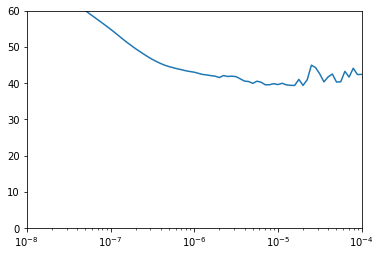

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size = 60,
                             batch_size = 100,
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [13]:
optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
30/30 [==============================] - 7s 119ms/step - loss: 51.2719 - mae: 51.7698
Epoch 2/500
30/30 [==============================] - 4s 120ms/step - loss: 41.6293 - mae: 42.1264
Epoch 3/500
30/30 [==============================] - 4s 117ms/step - loss: 40.7315 - mae: 41.2288
Epoch 4/500
30/30 [==============================] - 4s 118ms/step - loss: 40.4693 - mae: 40.9664
Epoch 5/500
30/30 [==============================] - 4s 117ms/step - loss: 40.4570 - mae: 40.9543
Epoch 6/500
30/30 [==============================] - 4s 118ms/step - loss: 40.5133 - mae: 41.0103
Epoch 7/500
30/30 [==============================] - 4s 120ms/step - loss: 40.0712 - mae: 40.5685
Epoch 8/500
30/30 [==============================] - 4s 118ms/step - loss: 39.3160 - mae: 39.8130
Epoch 9/500
30/30 [==============================] - 4s 117ms/step - loss: 38.4652 - mae: 38.9621
Epoch 10/500
30/30 [==============================] - 4s 117ms/step - loss: 38.4989 - mae: 38.9957
Epoch 11/500
30/30 

In [14]:
lstm_forecast = model_forecast(model, series[..., np.newaxis],
                               window_size)

lstm_forecast = lstm_forecast[split_time - window_size : -1, -1, 0]

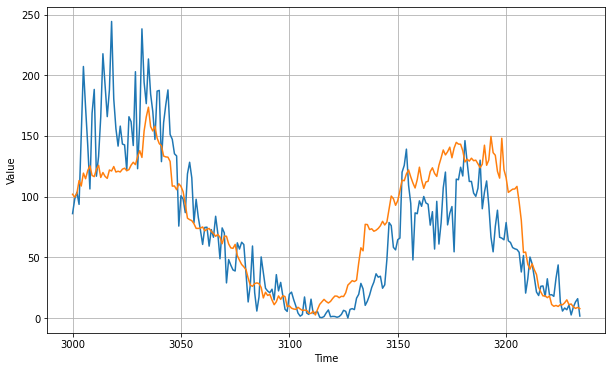

In [15]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

25.2122

<Figure size 432x288 with 0 Axes>

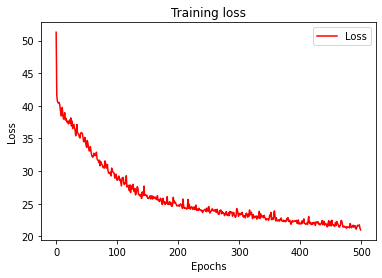

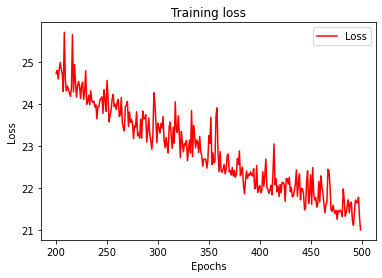

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on trainng and test data
# sets for each training epoch
#-----------------------------------------------------------

loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-----------------------------------------------------------
# Plot training and validation loss per epoch
#-----------------------------------------------------------

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

#-----------------------------------------------------------
# Plot zoomed training and validation loss per epoch
#-----------------------------------------------------------

zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(lstm_forecast)

[101.93913    99.528145  102.74075   113.20847   108.716095  119.34421
 114.71946   121.41595   125.352646  117.38496   116.4639    122.48045
 125.79726   115.77853   119.82123   116.645386  115.025925  121.90624
 121.11104   124.76923   120.22889   120.92469   120.29235   122.60651
 123.38966   121.347305  122.201584  125.916145  128.2897    126.32487
 132.81865   137.81966   132.29378   154.01245   165.6689    173.65114
 157.69746   154.08287   157.98645   148.2315    143.65121   141.96317
 133.3835    132.71596   132.50333   128.96558   108.60155   108.770226
 105.68945   110.595634  108.44534   104.02       93.76975    82.21031
  81.020065   80.202446   77.64225    73.828354   73.77839    74.05838
  74.97338    71.812386   73.02755    73.77939    71.29775    69.665924
  67.2934     68.8107     66.56483    61.17636    67.468796   67.32859
  61.00222    57.740044   57.373      60.62732    51.40834    47.570328
  44.085155   42.15294    39.834114   32.747036   27.04452    26.107922
  